In [1]:
import numpy as np
from pylab import*
import matplotlib.pyplot as plt
from h5py import File

#STIXGeneral

font = {'family' : 'STIXGeneral',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

## Accessing data

In [2]:
f = open('dict.txt','r')
data=f.read()
f.close()
data = eval(data)

In [3]:
""" 
LIST OF RUNES

# RUN 1 - trigger_period = 1.092 = 2*0.052 + 0.088 + 0.8 + 0.1
matrix_data534_label_e.txt  # 0 photon
matrix_data535_label_e.txt  # 1 photon

# RUN 2 - trigger_period = 1.092 = 2*0.052 + 0.088 + 0.8 + 0.1
matrix_data536_label_e.txt  # 0 photon
matrix_data537_label_e.txt  # 1 photon

# RUN 3 - trigger_period = 1.992 = 2*0.052 + 0.088 + 0.8 + 1
matrix_data871_label_e.txt  # 0 photon
matrix_data872_label_e.txt  # 1 photon

# RUN 4 - trigger_period = 1.984 = 0.184 + 0.8 + 1
matrix_data780_label_e.txt  # 1 photon
matrix_data781_label_e.txt  # 0 photon


"""

' \nLIST OF RUNES\n\n# RUN 1 - trigger_period = 1.092 = 2*0.052 + 0.088 + 0.8 + 0.1\nmatrix_data534_label_e.txt  # 0 photon\nmatrix_data535_label_e.txt  # 1 photon\n\n# RUN 2 - trigger_period = 1.092 = 2*0.052 + 0.088 + 0.8 + 0.1\nmatrix_data536_label_e.txt  # 0 photon\nmatrix_data537_label_e.txt  # 1 photon\n\n# RUN 3 - trigger_period = 1.992 = 2*0.052 + 0.088 + 0.8 + 1\nmatrix_data871_label_e.txt  # 0 photon\nmatrix_data872_label_e.txt  # 1 photon\n\n# RUN 4 - trigger_period = 1.984 = 0.184 + 0.8 + 1\nmatrix_data780_label_e.txt  # 1 photon\nmatrix_data781_label_e.txt  # 0 photon\n\n\n'

In [4]:
# Read the tab-delimited file
matrix = np.loadtxt('matrix_data534_label_e.txt', delimiter='\t', dtype=int)

print(matrix.shape)
print(matrix)

(10000, 21)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


In [5]:
# Convert to integer matrix
matrix_data = np.array([[int(value) for value in row] for row in matrix])
print(matrix_data)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


0
1
2
3
4
5
6
7
8
9


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

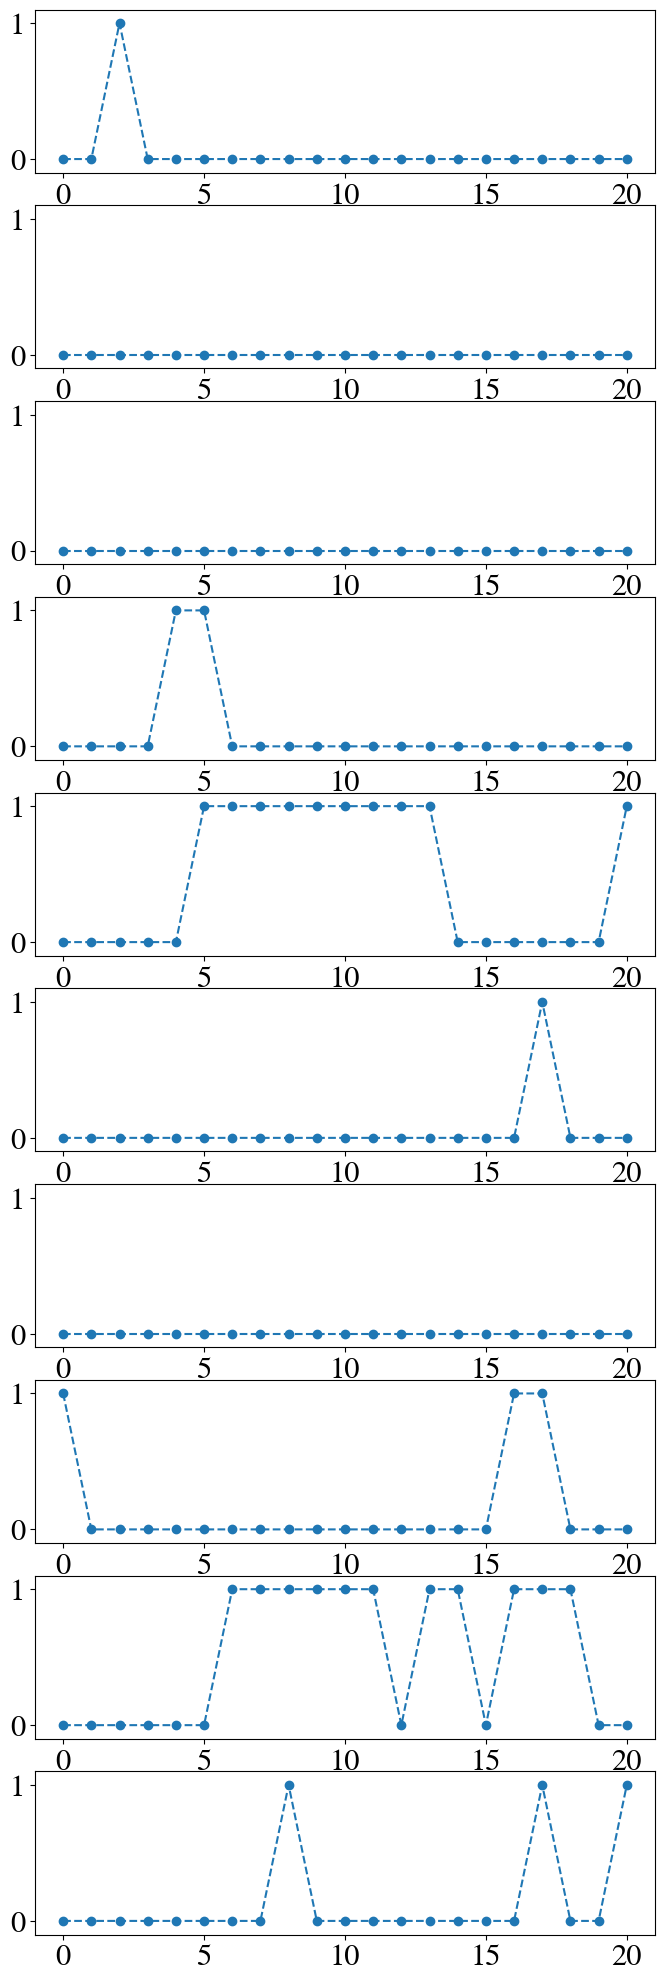

In [6]:
# Access data with a key. For each key there are a series of measurement sequences
# corresponding to the result of 30 repeated parity experiments
# Possible values for the parity expt are {0,1} representing the qubit ground and excited states

# Warning: The number of measurements sequences for each label is not the same!
# I had to perform more experiments when the probability of seeing a photon is smaller

# plotting the 14th measurmement for each injected population. nothing special about this, just an example

figure(figsize=(8,25))
array = np.random.rand(10000)
n_plots = 10
# Loop to plot 10 random values
for i in range(10):
    # Randomly sample one value from the array
    #random_value = np.random.choice(10000)
    subplot(n_plots, 1, i+1)
    ylim(-0.1,1.1)
    plot(matrix_data[100+i], 'o--')
    print(i)
    
tight_layout

In [7]:
print(data.keys()) # different values of injected mean photon population, these are the labels

dict_keys([0.08225683961245896, 0.36751853849630745, 0.01135324397826302, 0.007236769272169664, 0.004057906940956875, 0.028202605718902044, 0.001799469308404296, 5.826865227195515e-06, 0.017782789719525745, 0.01228339687027276, 0.0005649913217647377, 2.7708854882465167e-07, 0.0, 4.849147669242333e-05])


## Hidden Markov model

In [8]:
# Aalto device parameters

trigger_period = 1.092 #0.184+0.8+1 #10 # Total time of each parity measurement: 1.092 - 1.992 - 1.984. All times in micro seconds
parity_time = 0.088 #0.088 # 0.0 for run 4 # Period between pi/2 pulses
cav_t1 = 20 #545.8 # caviy decay time
qubit_t1 = 16.7 #108.65 # qubit decay time
qubit_t2 = 6.2 #60.67 # qubit dephasing time
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 5.07e-2 # residual qubit population
g_infidelity = 1-0.95739 # infidelity of qubit g readout
e_infidelity = 1-0.95739 # infidelity of qubit e readout
parity_err = 0

In [9]:
# Defining transition and emission matricies for the hidden Markov model (HMM)

P01 = cav_n * (1-exp(-trigger_period/cav_t1))
P10 = 1-exp(-trigger_period/cav_t1)
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2)) + parity_err
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2)) + parity_err

T = asarray([[(1-P01)*(1-Pge), (1-P01)*Pge, P01*Pge, P01*(1-Pge)],
     [(1-P01)*Peg, (1-P01)*(1-Peg), P01*(1-Peg), P01*Peg],
     [P10*(1-Pge), P10*Pge, (1-P10)*Pge, (1-P10)*(1-Pge)],
     [P10*Peg, P10*(1-Peg), (1-P10)*(1-Peg), (1-P10)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

print(T)
print(E)

[[9.82697537e-01 1.73024625e-02 0.00000000e+00 0.00000000e+00]
 [7.73904874e-02 9.22609513e-01 0.00000000e+00 0.00000000e+00]
 [5.22167955e-02 9.19386802e-04 1.63830757e-02 9.30480742e-01]
 [4.11223504e-03 4.90239472e-02 8.73585565e-01 7.32782523e-02]]
[[0.478695 0.021305]
 [0.021305 0.478695]
 [0.478695 0.021305]
 [0.021305 0.478695]]


In [10]:
# State reconstrution algorithms for the HMM

# probability of possible state at i-th time step given all previous measurements
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25] # assume flat prior
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha

# probability of future measurements given state at i-th time step
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)

        beta = zeros((N,num_meas))
        beta[:,-1:] = 1

        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])

        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()

# product of forward and backward probabilities
# probability of state at i-th time step given the entire measurement record
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

# returns the most likely state seqeunce given the measurement record
# not used in this work
def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states

In [11]:
meas_seq = [1, 0, 0]
print(forward(meas_seq,T,E))
print(E[:, meas_seq[0]]) # Vector 4x1
print([0.25,0.25,0.25,0.25]*E[:,meas_seq[0]]) # Vector 4x1
print(([0.25,0.25,0.25,0.25]*E[:,meas_seq[0]]).dot(T)) # Vector 4x1 = 4x1 x 4x4, transpone el vector si hace falta


[[5.32625000e-03 1.19673750e-01 5.32625000e-03 1.19673750e-01]
 [7.30773340e-03 2.47939225e-03 5.00870646e-02 2.92420847e-04]
 [4.78204888e-03 5.27157641e-05 5.15092480e-04 9.93377095e-04]]
[0.021305 0.478695 0.021305 0.478695]
[0.00532625 0.11967375 0.00532625 0.11967375]
[0.01526595 0.11637607 0.10463252 0.01372546]


## Example of the HMM reconstruction in action

1.0
0.15105960527001824
0.09723575896681334
0.06284175679468432
0.060128510121971554
0.05878747305667839
0.05865917297888786
0.058606450051304805
0.05869960196264896
0.05871669467300521
0.058612731852041605
0.05861003769046889
0.05860603205440609
0.05860585104297003
0.05860569760015076
0.0586056877627097
0.05860568182695865
0.05860568957170593
0.05860569089516897
0.05860568229071231
0.05860568583773563
[0 1 2 3 4]
[1, 5, 10, 15, 21]


Text(0.5, 0, 'Number of Parity Measurements')

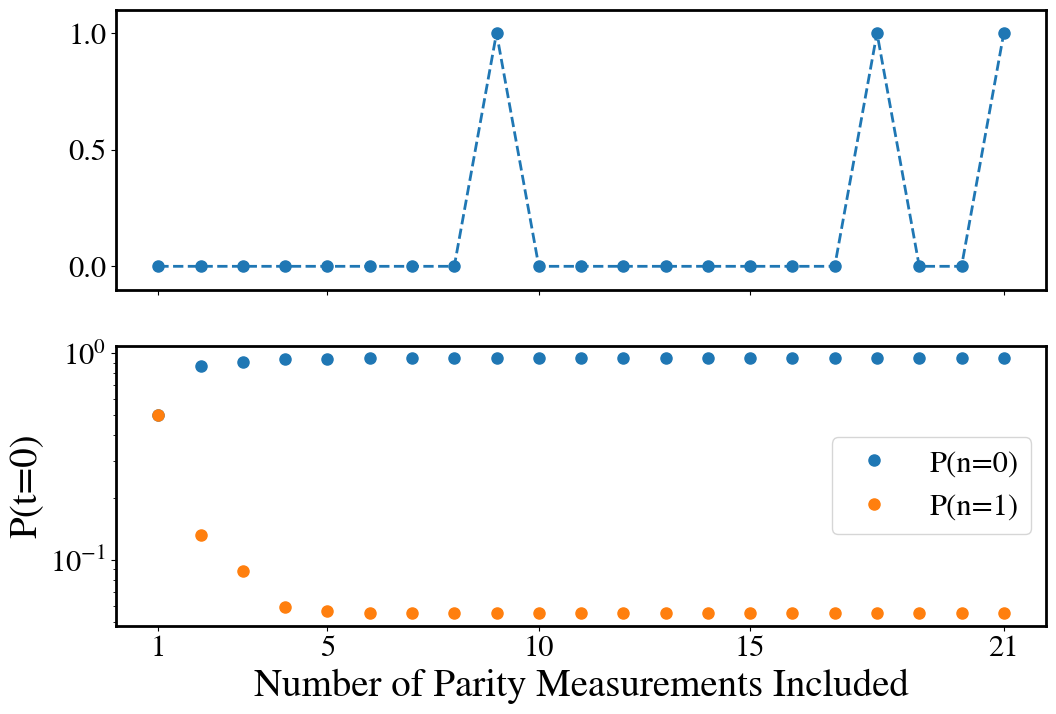

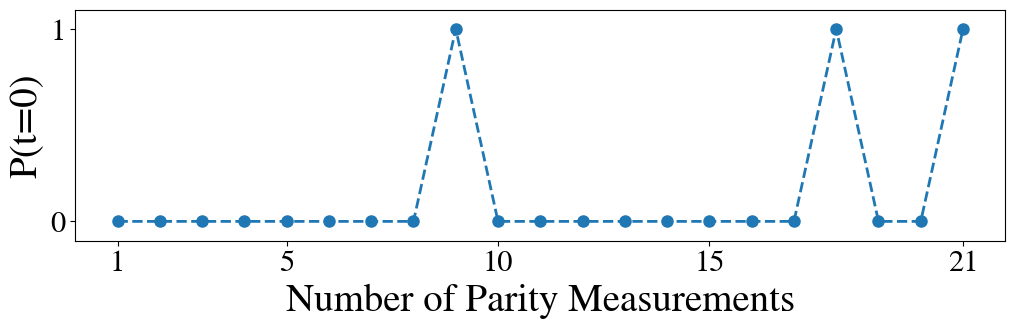

In [12]:
#meas_sequence = data[list(data.keys())[1]][14]
meas_sequence = matrix_data[109]

# want to compute the probabilities of 0 or 1 photon initially in the cavity
P0_first = []
P1_first = []

# iteratively calculate probabilities using one additional measurement at a time
# observe how probabilities 'evolve' with more meaurements in the recrod
for ii in range (len(meas_sequence)):
    
    # analyze subeset of measurment record from beginning to ii-th measuement
    # could be implemented online to do feedback in the measurement
    temp_meas_sequence = meas_sequence[0:ii+1]
    
    # forward-backward algorithm return state probabilities at each step
    gamma_matrix = gamma(temp_meas_sequence, T, E)
    
    # pick off probability of cavitiy state at the beginning, 0 in the first index
    # sum over qubit state probability, second index
    P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
    P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])
    print((gamma_matrix[0,2] + gamma_matrix[0,3])/(gamma_matrix[0,0] + gamma_matrix[0,1]))

figure(figsize = (12,8))

# plot measurement record
ax1 = subplot(2,1,1)
plot(meas_sequence, 'o--', markersize=8, linewidth=2)
ylim(-0.1, 1.1)
plt.xticks([0, 4, 9, 14, 20], [1, 5, 10, 15, 21])
plt.tick_params('x', labelbottom=False)

# plot reconstructed probabilities for subsets of the measurement record
ax2 = subplot(2,1,2)
semilogy(P0_first, 'o', label= "P(n=0)", markersize=8, linewidth=2)
semilogy(P1_first, 'o', label= "P(n=1)", markersize=8, linewidth=2)
#         axhline(1e-9)
#         plot(P0_first, 'o', label= "P(n=0)")
#         plot(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-8)
#         ylim(1e-16,1e0)
ylabel('P(t=0)', size = 28)
xlabel('Number of Parity Measurements Included', size = 28)

for spine in ax1.spines.values():
    spine.set_linewidth(2)  # Change thickness as needed
for spine in ax2.spines.values():
    spine.set_linewidth(2)  # Change thickness as needed

plt.xticks([0, 4, 9, 14, 20], [1, 5, 10, 15, 21])
legend(loc='center right')
tight_layout

figure(figsize = (12,3))
plot(meas_sequence, 'o--', markersize=8, linewidth=2)
ylim(-0.1, 1.1)
custom_ticks = np.linspace(0, 1, 2, dtype=int)
ax = plt.gca()
ax.set_yticks(custom_ticks)
ax.set_yticklabels(custom_ticks)
#plt.xticks(np.arange(len(meas_sequence)), np.arange(1, len(meas_sequence)+1))
plt.xticks([0, 4, 9, 14, 20], [1, 5, 10, 15, 21])
print(np.arange(5))
print([1, 5, 10, 15, 21])
ylabel('P(t=0)', size = 28)
xlabel('Number of Parity Measurements', size = 28)
#tight_layout

In [13]:
state_list = matrix_data
dif = np.zeros(len(matrix_data[0]))
div = np.zeros(len(matrix_data[0]))

#events = len(state_list)
events = 100

for i in range (events):
    meas_sequence = matrix_data[i]
    
    # iteratively calculate probabilities using one additional measurement at a time
    # observe how probabilities 'evolve' with more meaurements in the recrod
    for ii in range (len(meas_sequence)):

        # analyze subeset of measurment record from beginning to ii-th measuement
        # could be implemented online to do feedback in the measurement
        temp_meas_sequence = meas_sequence[0:ii+1]

        # forward-backward algorithm return state probabilities at each step
        gamma_matrix = gamma(temp_meas_sequence, T, E)

        # pick off probability of cavitiy state at the beginning, 0 in the first index
        # sum over qubit state probability, second index
        P0_first = gamma_matrix[0,0] + gamma_matrix[0,1]
        P1_first = gamma_matrix[0,2] + gamma_matrix[0,3]

        dif[ii] = dif[ii] + np.abs(P1_first - P0_first)/events
        div[ii] = div[ii] + (P1_first / P0_first)/events
    #print(dif)
    #print(div)

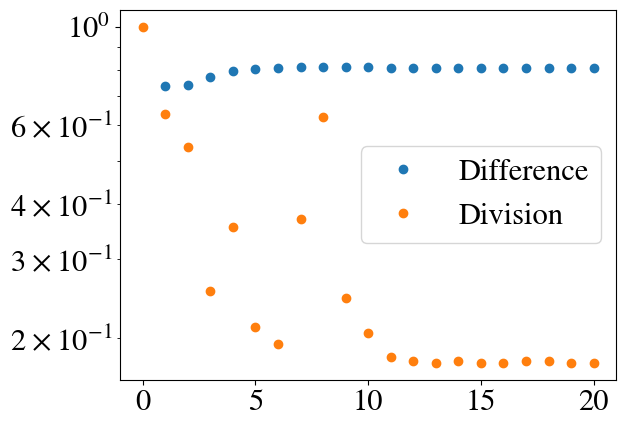

In [14]:
semilogy(dif, 'o', label= "Difference")
semilogy(div, 'o', label= "Division")
legend()

## Analyzing dataset

In [15]:
# Use the HMM to determine the likelihood that a measurement sequence
# is the result of a cavity photon present in the beginning

start = 0
stop = 21

#state_dict = data
#state_dict = matrix_data

threshold_list = [2,10,20,50,1e2,2e2,4e2,1e3,2e3,5e3,1e4,4e4,1e5,4e5,1e6,4e6,1e7,4e7,1e8,1e9]
# threshold_list = [1,2,5,10,20,1e2,2e2,4e2,7e2,1e3,2e3,7e3,1e4,2e4,4e4,1e5]
# threshold_list = [1,10,1e2,1e3,1e4,1e5]
# threshold_list = [500,800,1000,1200,1300,1400,1500,1800,2000,10000]
# threshold_list = [1e5,1e6,1e7,1e8,1e9]
# threshold_list = [1e5] # likehood threshold above which, an event is considered a detection

first_count_dict_list = []
meas_num_dict_list = []
L_ratio_list = []
state_list = matrix_data
"""
a = 0
for thresh in threshold_list:
    first_count_dict = {}
    meas_num_dict = {}

    
    #print(state_list)
    meas_num_dict = len(state_list)
    #print(meas_num_dict )
    first_detected_state_list = []
    max_L = []
    for ii in range (len(state_list)):
        meas_seq = state_list[ii][start:stop]
        gamma_matrix = gamma(meas_seq, T, E)

        P0 = gamma_matrix[0,0] + gamma_matrix[0,1]
        P1 = gamma_matrix[0,2] + gamma_matrix[0,3]

        # Compare the probabilities of the two models to obtain a likelihood ratio
        likelihood_ratio = P1/P0  
        if a == 0: 
            L_ratio_list.append(likelihood_ratio)
                 
            
        if likelihood_ratio>thresh:
            first_detected_state_list.append(1)
        else:
            first_detected_state_list.append(0)
    first_count_dict = sum(first_detected_state_list)
    print(first_count_dict)
    a=1 

"""

for ii in range (len(state_list)):
    meas_seq = state_list[ii][start:stop]
    gamma_matrix = gamma(meas_seq, T, E)

    P0 = gamma_matrix[0,0] + gamma_matrix[0,1]
    P1 = gamma_matrix[0,2] + gamma_matrix[0,3]

    # Compare the probabilities of the two models to obtain a likelihood ratio
    likelihood_ratio = P1/P0  
    L_ratio_list.append(likelihood_ratio)


for thresh in threshold_list:
    first_count_dict = {}
    first_detected_state_list = []
    for i in L_ratio_list:    
        if i>thresh:
            first_detected_state_list.append(1)
        else:
            first_detected_state_list.append(0)
    first_count_dict = sum(first_detected_state_list)
    #print(first_count_dict)
    


    """
    for p1 in state_dict:
        state_list = state_dict[p1]
        print(state_list)
        meas_num_dict[p1] = len(state_list)
        print(meas_num_dict[p1] )
        first_detected_state_list = []
        max_L = []
        for ii in range (len(state_list)):
            meas_seq = state_list[ii][start:stop]
            gamma_matrix = gamma(meas_seq, T, E)

            P0 = gamma_matrix[0,0] + gamma_matrix[0,1]
            P1 = gamma_matrix[0,2] + gamma_matrix[0,3]

            # Compare the probabilities of the two models to obtain a likelihood ratio
            likelihood_ratio = P1/P0        
                
            if likelihood_ratio>thresh:
                first_detected_state_list.append(1)
            else:
                first_detected_state_list.append(0)
        first_count_dict[p1] = sum(first_detected_state_list)
    """

    #for dic in [first_count_dict, meas_num_dict]:
    #    del dic[2.7708854882465167e-07]
    #    del dic[0.01228339687027276]
    first_count_dict_list.append(first_count_dict)
    #meas_num_dict_list.append(meas_num_dict)
print(first_count_dict_list)

[115, 52, 39, 23, 18, 17, 13, 12, 9, 8, 7, 4, 4, 4, 2, 2, 2, 2, 1, 1]


[0.05859848393766784, 0.10227150691884027, 0.05879754670160463, 0.05859814907522341, 0.05859814907522341, 0.05859814907522341, 0.05859814907745235, 0.05859815054751327, 0.05860635158725287, 0.05859814910359933, 0.05859814907522341, 0.0586269124537084, 0.05879754670160463, 0.0585981637228565, 0.4513129622955075, 0.05859814907522341, 0.4512954924896941, 0.05859814907522341, 0.05859814907522341, 0.05859814907522341, 0.0722857949738443, 0.05859814907522341, 0.05859814907522341, 0.058598149173057175, 1.2201150628155304, 3.9948091979504414, 0.05876373197971283, 0.05876368627915033, 0.05859814907522341, 0.05859814907522341, 0.05859814907522341, 0.05859814907522341, 0.060302633799312715, 0.05859814907522341, 0.05859814907522341, 0.1286508686923029, 0.2900375885410673, 0.05859814907522341, 0.05859848393766784, 0.05859814907522341, 0.05859814907522341, 0.0621124456009703, 0.05859814907522341, 0.060302633799312715, 0.05859814907522341, 0.05859814907522341, 0.9087117338370552, 0.6669347840960109, 

Text(0.5, 0, 'Likelihood ratio')

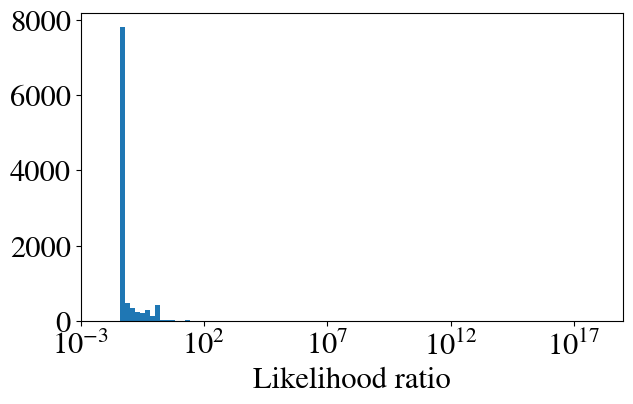

In [16]:
p1 = 1
print(L_ratio_list)
print("Expected Counts %.3f" %(p1*len(L_ratio_list)))
print("n_inj: %.7f, N: %.1f" %(p1, len(L_ratio_list)))
#     axvline(thresh)
#     title("n_inj: %.7f, N: %.1f" %(p1, len(L_ratio[p1])))
figure(figsize = (7,4))
hist(L_ratio_list, bins=logspace(-2,18,100))
xscale('log')
#yscale('log')
#ylim(0,40)
xlabel("Likelihood ratio")

[0.6678, 0.574, 0.5432, 0.5005, 0.4638, 0.4394, 0.4149, 0.3814, 0.3523, 0.3223, 0.302, 0.2566, 0.2279, 0.1915, 0.1678, 0.1382, 0.1145, 0.087, 0.0678, 0.0404]
[172.2072476789458, 90.59233449477352, 71.79675994108983, 45.95404595404596, 38.809831824062094, 38.68912152935822, 31.332851289467342, 31.463030938647087, 25.546409310246947, 24.821594787465095, 23.17880794701987, 15.58846453624318, 17.551557700745942, 20.887728459530027, 11.918951132300357, 14.471780028943561, 17.46724890829694, 22.98850574712644, 14.749262536873157, 24.752475247524753]
[861.036238394729, 452.9616724738676, 358.98379970544914, 229.77022977022978, 194.04915912031046, 193.44560764679107, 156.6642564473367, 157.31515469323543, 127.73204655123473, 124.10797393732547, 115.89403973509934, 77.9423226812159, 87.7577885037297, 104.43864229765013, 59.594755661501786, 72.35890014471781, 87.3362445414847, 114.9425287356322, 73.74631268436578, 123.76237623762376]
Counts:  4
5
20
4
Bkg rate:  77.9423226812159
87.3515024458420

Text(0.5, 1.0, 'Background level corrected with readout efficiency')

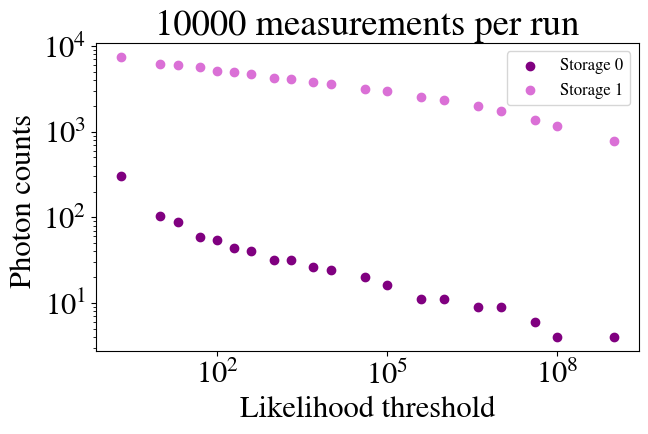

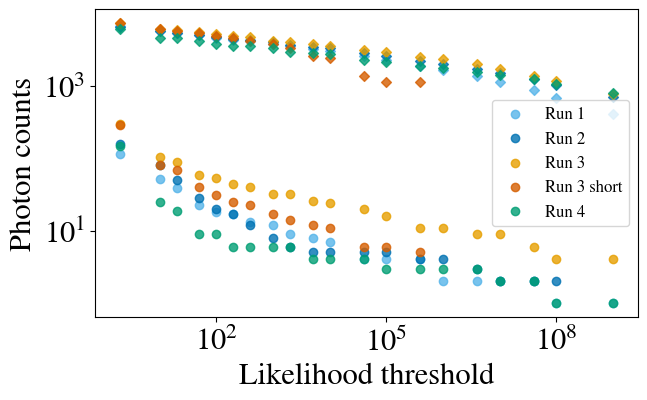

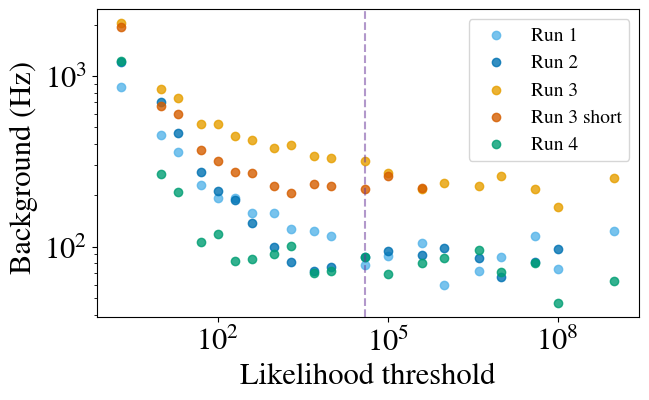

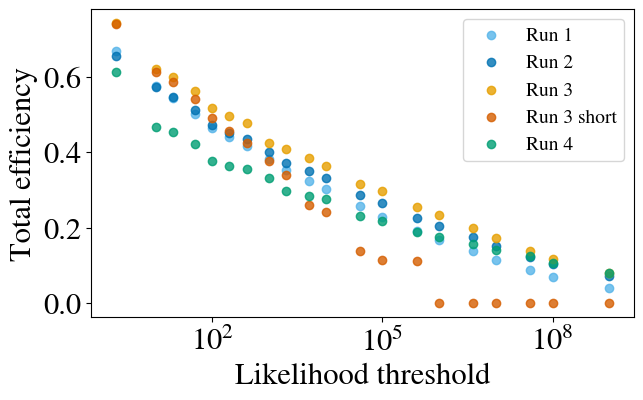

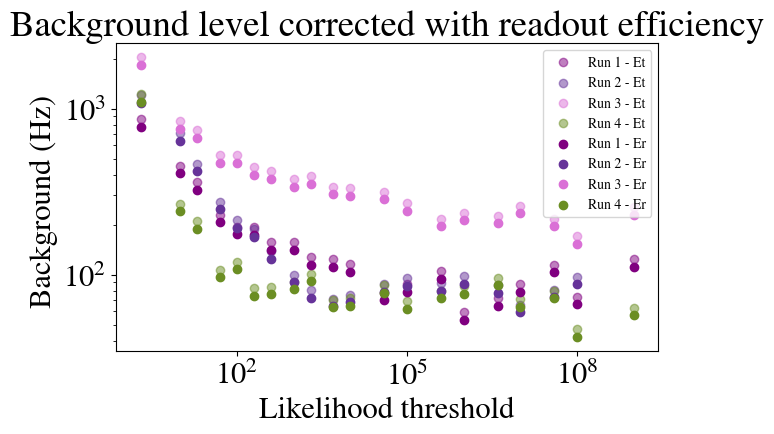

In [17]:
threshold_list = [2,10,20,50,1e2,2e2,4e2,1e3,2e3,5e3,1e4,4e4,1e5,4e5,1e6,4e6,1e7,4e7,1e8,1e9]
injecting_eff = 0.9

###### RUN 1 ######
# Not injecting phtons 
#photon_counts_0_534= [53, 24, 17, 12, 8, 7, 5, 4, 4, 3, 2, 2, 2, 2, 2, 0] #trigger_period = 0.1
photon_counts_0_534= [115, 52, 39, 23, 18, 17, 13, 12, 9, 8, 7, 4, 4, 4, 2, 2, 2, 2, 1, 1] #trigger_period = 1.092
# Injecting phtons 
#photon_counts_1_535= [5618, 4878, 4563, 3998, 3562, 3255, 2649, 2324, 2082, 1771, 1592, 1284, 1085, 794, 717, 392] #trigger_period = 0.1
photon_counts_1_535= [6678, 5740, 5432, 5005, 4638, 4394, 4149, 3814, 3523, 3223, 3020, 2566, 2279, 1915, 1678, 1382, 1145, 870, 678, 404] #trigger_period = 1.092

efficiency_Run1 = [x / 10000. for x in photon_counts_1_535]
bkgCounts_Run1 = [x / y for x, y in zip(photon_counts_0_534, efficiency_Run1)] 
bkgRate_Run1 = [x / (10000*0.00002) for x in bkgCounts_Run1]

# Correcting only due to readout efficiency (e.g. removing injecting efficiency)
read_efficiency_Run1 = [y / injecting_eff for y in efficiency_Run1]
bkgCounts_readEff_Run1 = [x / y for x, y in zip(photon_counts_0_534, read_efficiency_Run1)]
bkgRate_readEff_Run1 = [x / (10000*0.00002) for x in bkgCounts_readEff_Run1]

print(efficiency_Run1)
print(bkgCounts_Run1)
print(bkgRate_Run1)

###### RUN 2 ######
# Not injecting phtons 
#photon_counts_0_536= [71, 35, 22, 14, 9, 6, 5, 5, 5, 4, 3, 3, 2, 2, 2, 1] #trigger_period = 0.1
photon_counts_0_536= [158, 81, 51, 28, 20, 17, 12, 8, 6, 5, 5, 5, 5, 4, 4, 3, 2, 2, 2, 0] #trigger_period = 1.092

# Injecting phtons 
#photon_counts_1_537= [5607, 4998, 4680, 4142, 3716, 3438, 2889, 2584, 2373, 2103, 1924, 1594, 1430, 1147, 1081, 655] #trigger_period = 0.1
photon_counts_1_537= [6548, 5723, 5472, 5102, 4719, 4514, 4342, 4013, 3711, 3492, 3311, 2862, 2639, 2247, 2047, 1741, 1514, 1231, 1032, 705] #trigger_period = 1.092

efficiency_Run2 = [x / 10000. for x in photon_counts_1_537]
bkgCounts_Run2 = [x / y for x, y in zip(photon_counts_0_536, efficiency_Run2)] 
bkgRate_Run2 = [x / (10000*0.00002) for x in bkgCounts_Run2]
# Correcting only due to readout efficiency (e.g. removing injecting efficiency)
read_efficiency_Run2 = [y / injecting_eff for y in efficiency_Run2]
bkgCounts_readEff_Run2 = [x / y for x, y in zip(photon_counts_0_536, read_efficiency_Run2)]
bkgRate_readEff_Run2 = [x / (10000*0.00002) for x in bkgCounts_readEff_Run2]

###### RUN 3 ######
# Not injecting phtons 
#photon_counts_0_871= [103, 66, 60, 45, 33, 28, 18, 16, 15, 12, 11, 9, 8, 7, 6, 5] #trigger_period = 0.1
photon_counts_0_871= [303, 104, 89, 59, 54, 44, 40, 32, 32, 26, 24, 20, 16, 11, 11, 9, 9, 6, 4, 4] #trigger_period = 1.992
# Injecting phtons 
#photon_counts_1_872= [6017, 5354, 5041, 4509, 4033, 3734, 3193, 2928, 2671, 2397, 2249, 1929, 1725, 1447, 1381, 891] #trigger_period = 0.1
photon_counts_1_872= [7418, 6192, 5988, 5614, 5158, 4948, 4759, 4248, 4075, 3832, 3630, 3165, 2966, 2533, 2330, 1985, 1732, 1381, 1176, 787] #trigger_period = 1.992

efficiency_Run3 = [x / 10000. for x in photon_counts_1_872]
bkgCounts_Run3 = [x / y for x, y in zip(photon_counts_0_871, efficiency_Run3)] 
bkgRate_Run3 = [x / (10000*0.00002) for x in bkgCounts_Run3]
# Correcting only due to readout efficiency (e.g. removing injecting efficiency)
read_efficiency_Run3 = [y / injecting_eff for y in efficiency_Run3]
bkgCounts_readEff_Run3 = [x / y for x, y in zip(photon_counts_0_871, read_efficiency_Run3)]
bkgRate_readEff_Run3 = [x / (10000*0.00002) for x in bkgCounts_readEff_Run3]

###### RUN 4 ######
# parity_time = 0
# Not injecting phtons 
photon_counts_0_781= [149, 25, 19, 9, 9, 6, 6, 6, 6, 4, 4, 4, 3, 3, 3, 3, 2, 2, 1, 1]
# Injecting phtons
photon_counts_1_780= [6112, 4676, 4544, 4208, 3768, 3625, 3544, 3306, 2970, 2838, 2768, 2309, 2163, 1871, 1757, 1566, 1412, 1247, 1070, 793]

efficiency_Run4 = [x / 10000. for x in photon_counts_1_780]
bkgCounts_Run4 = [x / y for x, y in zip(photon_counts_0_781, efficiency_Run4)] 
bkgRate_Run4 = [x / (10000*0.00002) for x in bkgCounts_Run4]
# Correcting only due to readout efficiency (e.g. removing injecting efficiency)
read_efficiency_Run4 = [y / injecting_eff for y in efficiency_Run4]
bkgCounts_readEff_Run4 = [x / y for x, y in zip(photon_counts_0_781, read_efficiency_Run4)]
bkgRate_readEff_Run4 = [x / (10000*0.00002) for x in bkgCounts_readEff_Run4]

###### RUN 3 SHORT ######
# Not injecting phtons 
photon_counts_0_871_11= [286, 82, 70, 40, 31, 25, 23, 17, 14, 12, 11, 6, 6, 5, 0, 0, 0, 0, 0, 0]
# Injecting phtons 
photon_counts_1_872_11= [7391, 6126, 5846, 5402, 4896, 4546, 4236, 3773, 3402, 2592, 2412, 1383, 1152, 1127, 0, 0, 0, 0, 0, 0]
# Injecting phtons 
photon_counts_1_872_6= [6790, 5561, 4931, 3016, 1, 3016, 3016, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

efficiency_Run3Short = [x / 10000. for x in photon_counts_1_872_11]
bkgCounts_Run3Short = [x / y for x, y in zip(photon_counts_0_871_11[0:14], efficiency_Run3Short[0:14])] 
bkgRate_Run3Short = [x / (10000*0.00002) for x in bkgCounts_Run3Short]


# Create scatter plot
figure(figsize = (7,4))
#plt.scatter(threshold_list, photon_counts_0_534, color='blue', label='Storage 0')
#plt.scatter(threshold_list, photon_counts_1_535, color='red', label='Storage 1')

#plt.scatter(threshold_list, photon_counts_0_536, color='royalblue', label='Storage 0')
#plt.scatter(threshold_list, photon_counts_1_537, color='tomato', label='Storage 1')

plt.scatter(threshold_list, photon_counts_0_871, color='purple', label='Storage 0')
plt.scatter(threshold_list, photon_counts_1_872, color='orchid', label='Storage 1')

#plt.scatter(threshold_list, photon_counts_0_871_11, color='tomato', label='Storage 0')
#plt.scatter(threshold_list, photon_counts_1_872_11, color='tomato', label='Storage 1')

#plt.scatter(threshold_list, photon_counts_1_872_6, color='red', label='Storage 1')

plt.xscale('log')
plt.yscale('log')

# Adding labels and title
plt.xlabel('Likelihood threshold')
plt.ylabel('Photon counts ')
plt.title('10000 measurements per run')

# Show legend
plt.legend(fontsize=12)


###### COUNTS #######
colors = [ '#56B4E9', '#0072B2', '#E69F00', '#D55E00', '#009E73']

figure(figsize = (7,4))
plt.scatter(threshold_list, photon_counts_0_534, color=colors[0], label='Run 1', alpha=0.8)
plt.scatter(threshold_list, photon_counts_0_536, color=colors[1], label='Run 2', alpha=0.8)
plt.scatter(threshold_list, photon_counts_0_871, color=colors[2], label='Run 3', alpha=0.8)
plt.scatter(threshold_list, photon_counts_0_871_11, color=colors[3], label='Run 3 short', alpha=0.8)
plt.scatter(threshold_list, photon_counts_0_781, color=colors[4], label='Run 4', alpha=0.8)

plt.scatter(threshold_list, photon_counts_1_535, color=colors[0], marker="D", s=25, alpha=0.8)
plt.scatter(threshold_list, photon_counts_1_537, color=colors[1], marker="D", s=25, alpha=0.8)
plt.scatter(threshold_list, photon_counts_1_872, color=colors[2], marker="D", s=25, alpha=0.8)
plt.scatter(threshold_list, photon_counts_1_872_11, color=colors[3], marker="D", s=25, alpha=0.8)
plt.scatter(threshold_list, photon_counts_1_780, color=colors[4], marker="D", s=25, alpha=0.8)

"""
plt.scatter(threshold_list, photon_counts_0_534, color='purple', label='Run 1')
plt.scatter(threshold_list, photon_counts_0_536, color='rebeccapurple', label='Run 2')
plt.scatter(threshold_list, photon_counts_0_871, color='orchid', label='Run 3')
plt.scatter(threshold_list, photon_counts_0_871_11, color='tomato', label='Run 3 short')
plt.scatter(threshold_list, photon_counts_0_781, color='olivedrab', label='Run 4')

plt.scatter(threshold_list, photon_counts_1_535, color='purple', marker="D")
plt.scatter(threshold_list, photon_counts_1_537, color='rebeccapurple', marker="D")
plt.scatter(threshold_list, photon_counts_1_872, color='orchid', marker="D")
plt.scatter(threshold_list, photon_counts_1_872_11, color='tomato', marker="D")
plt.scatter(threshold_list, photon_counts_1_780, color='olivedrab', marker="D")
"""

plt.xscale('log')
plt.yscale('log')

# Adding labels and title
plt.legend(fontsize=12)
plt.xlabel('Likelihood threshold')
plt.ylabel('Photon counts')
#plt.title('Background level per threshold')

print("Counts: ", photon_counts_0_534[11])
print(photon_counts_0_536[11])
print(photon_counts_0_871[11])
print(photon_counts_0_781[11])

###### BACKGROUND #######
figure(figsize = (7,4))

plt.scatter(threshold_list, bkgRate_Run1, color=colors[0], label='Run 1', alpha=0.8)
plt.scatter(threshold_list, bkgRate_Run2, color=colors[1], label='Run 2', alpha=0.8)
plt.scatter(threshold_list, bkgRate_Run3, color=colors[2], label='Run 3', alpha=0.8)
plt.scatter(threshold_list[0:14], bkgRate_Run3Short, color=colors[3], label='Run 3 short', alpha=0.8)
plt.scatter(threshold_list, bkgRate_Run4, color=colors[4], label='Run 4', alpha=0.8)
plt.xscale('log')
plt.yscale('log')

plt.axvline(4e4, linestyle='--', color = 'rebeccapurple', alpha = 0.5)

print("Bkg rate: ", bkgRate_Run1[11])
print(bkgRate_Run2[11])
print(bkgRate_Run3[11])
print(bkgRate_Run4[11])

# Adding labels and title
plt.legend(fontsize=14)
plt.xlabel('Likelihood threshold')
plt.ylabel('Background (Hz) ')
#plt.title('Background level per threshold')

###### EFFICIENCY #######
figure(figsize = (7,4))
plt.scatter(threshold_list, efficiency_Run1, color=colors[0], label='Run 1', alpha=0.8)
plt.scatter(threshold_list, efficiency_Run2, color=colors[1], label='Run 2', alpha=0.8)
plt.scatter(threshold_list, efficiency_Run3, color=colors[2], label='Run 3', alpha=0.8)
plt.scatter(threshold_list, efficiency_Run3Short, color=colors[3], label='Run 3 short', alpha=0.8)
plt.scatter(threshold_list, efficiency_Run4, color=colors[4], label='Run 4', alpha=0.8)
plt.xscale('log')
#plt.yscale('log')

print("Efficiency: ", efficiency_Run1[11])
print(efficiency_Run2[11])
print(efficiency_Run3[11])
print(efficiency_Run4[11])

# Adding labels and title
plt.legend(fontsize=14)
plt.xlabel('Likelihood threshold')
plt.ylabel('Total efficiency')
#plt.title('Background level per threshold')

figure(figsize = (7,4))
plt.scatter(threshold_list, bkgRate_Run1, color='purple', alpha = 0.5, label='Run 1 - Et')
plt.scatter(threshold_list, bkgRate_Run2, color='rebeccapurple', alpha = 0.5, label='Run 2 - Et')
plt.scatter(threshold_list, bkgRate_Run3, color='orchid', alpha = 0.5, label='Run 3 - Et')
plt.scatter(threshold_list, bkgRate_Run4, color='olivedrab', alpha = 0.5, label='Run 4 - Et')

plt.scatter(threshold_list, bkgRate_readEff_Run1, color='purple', label='Run 1 - Er')
plt.scatter(threshold_list, bkgRate_readEff_Run2, color='rebeccapurple', label='Run 2 - Er')
plt.scatter(threshold_list, bkgRate_readEff_Run3, color='orchid', label='Run 3 - Er')
plt.scatter(threshold_list, bkgRate_readEff_Run4, color='olivedrab', label='Run 4 - Er')

plt.xscale('log')
plt.yscale('log')

# Adding labels and title
plt.legend(fontsize=10)
plt.xlabel('Likelihood threshold')
plt.ylabel('Background (Hz) ')
plt.title('Background level corrected with readout efficiency')

0.0007494210482557507


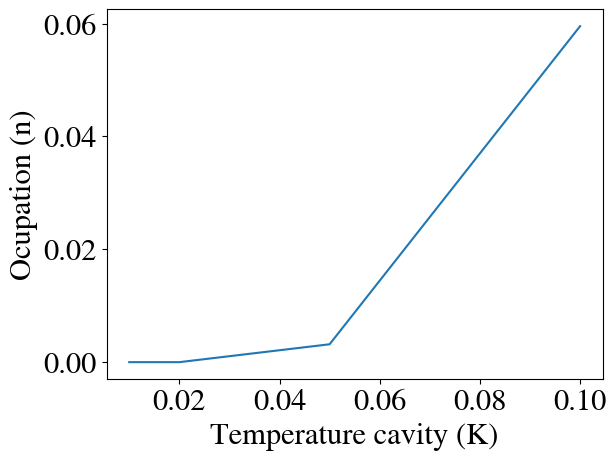

In [18]:
# Conversión de ocupacion de la cavidad a temperatura

# Constants
h = 6.626e-34  # Planck's constant (J·s)
k_B = 1.381e-23  # Boltzmann constant (J/K)
f = 6e9  # Frequency of the photons (Hz)

# Energy of a photon
E_photon = h * f

T_env = [0.01, 0.02, 0.05, 0.1]
# Photon number density using Bose-Einstein distribution
n = [1 / (np.exp(h * f / (k_B * t)) - 1) for t in T_env]

print(1 / (np.exp(h * f / (k_B * 0.04)) - 1))

plt.xlabel('Temperature cavity (K)')
plt.ylabel('Ocupation (n)')
plt.plot(T_env, n)

In [19]:
# Akash funciton for temperature - ocupation conversion
from scipy.optimize import curve_fit

def photon_counter_line(x, eff, err):
    return eff*(x)+err

def temperature_c(nu,occ):
    Kb = 1.381e-23
    h = 6.626e-34
    return h*nu/(Kb*log(1/occ+1))

In [20]:
# Comprobación de que ambas (funcion de Akash y mia) coinciden
print( "n =", 1 / (np.exp(h * f  / (k_B * 0.04)) - 1)) # Ocupation number for 0.04 K temperature.
temperature_c(f, 0.000749) # Ocupation number given by Akash

n = 0.0007494210482557507


0.03999687910000997

In [21]:
# Relation dark count rate and ocupation number: Rate = n * eff * delta_f
# Delta_f is the the linewidth of the scaning cavity: delta_f = fc/Q This is the inverse of T1

T1_s = 546e-6
Q_s = 2.06e7
f_s = 6.011e9

delta_f = (2*np.pi*f_s/Q_s)
n = 0.00073
photons = 9
totalMeasurements = 15141
efficiency = 0.409

DarkCountRate = photons/(totalMeasurements*T1_s)
computed_n = DarkCountRate / (efficiency*delta_f)
Q_s/(2*np.pi*f_s) # T1 = Q/(2pi*f)

print(delta_f)
print("Background rate: ", DarkCountRate)
print("Ocupation number: ", computed_n) # Sale justo el doble...
print("Ocupation number 2: ", DarkCountRate * T1_s/efficiency) # Sale justo el doble...

1833.4090719153635
Background rate:  1.0886676232426182
Ocupation number:  0.0014518194933726876
Ocupation number 2:  0.0014533313503434465


In [22]:
# Bkg paris haloscope
# 10^-5 photons in 400ms
photons = 1e-5
time = 0.4 # s
photons/time

2.5e-05

In [23]:
# Ocupación cavidad Aalto: 100 Hz, T1_s = 20 us, freq 5GHz
n = 100 * 20e-6
f = 5e9

print("Background rate (Hz): ", 100)
print("Ocupation: ", n)
print("Temperature (K): ", temperature_c(f, n))


Background rate (Hz):  100
Ocupation:  0.002
Temperature (K):  0.038589966982709105


In [24]:
# Ocupación cavidad Akash: ? Hz, T1_s = 546 us, freq 6.011 GHz, Q = 2.06e7 n = 0.00073, T = 39.9 mK
rate = 0.00073 / (546e-6)
print(rate) # In Hz

1.336996336996337


In [25]:
# Akash photon count
t1_Akash = 546e-6 # us
photons = 9
efficiency = 0.4
correctedPhotons = photons/efficiency
print("Background rate: ", photons/(15141*t1_Akash))
print("Background rate corrected: ", correctedPhotons/(15141*t1_Akash))

Background rate:  1.0886676232426182
Background rate corrected:  2.7216690581065452


In [26]:
# A Flux-Tunable cavity for Dark matter detection
rate2 = 64 # Hz
freq2 = 5.672e9 # Hz
T1_2 = 65e-6 # us
n2 = 0.0086 # Ocupation number
temp2 = 0.057 # temperature in K
print("Measured rate (Hz): ", 91/(20000*T1_2))

# Check formulas to relate these numbers
print("Rate: ", n2 / T1_2)
print("Ocupation number: ", rate2 * T1_2)
print("Temperature (K): ", temperature_c(freq2, n2))

Measured rate (Hz):  70.00000000000001
Rate:  132.30769230769232
Ocupation number:  0.00416
Temperature (K):  0.057117805263691555


In [27]:
# A Flux-Tunable cavity for Dark matter detection
f_s = 5.680e9
T1_s = 65e-6
Q_s = T1_s * (2*np.pi*f_s) 

delta_f = (2*np.pi*f_s/Q_s)
n = 0.0086
photons = 91
totalMeasurements = 20000
efficiency = 0.14

DarkCountRate = photons/(totalMeasurements*T1_s)
computed_n = DarkCountRate / (efficiency*delta_f)
Q_s/(2*np.pi*f_s) # T1 = Q/(2pi*f)

print(delta_f)
print(1/T1_s)
print("Background rate: ", DarkCountRate)
print("Ocupation number: ", computed_n)

15384.615384615387
15384.615384615387
Background rate:  70.00000000000001
Ocupation number:  0.0325


AttributeError: 'numpy.int64' object has no attribute 'keys'

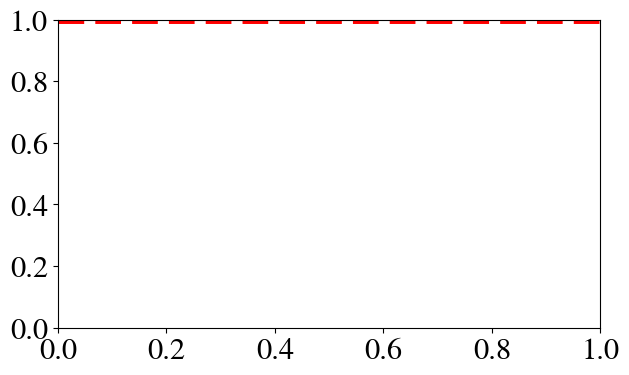

In [28]:
# threshold_list = [1,2,5,10,20,1e2,4e2,1e3,2e3,1e4,4e4,1e5,4e5,1e6,4e6,1e7,4e7,1e8,1e9]
# threshold_list = [1,2,5,10,20,1e2,2e2,4e2,7e2,1e3,2e3,7e3,1e4,2e4,4e4,1e5]
# threshold_list = [500,800,1000,1200,1300,1400,1500,1800,2000,10000]
# threshold_list = [1e5,1e6,1e7,1e8,1e9]
# threshold_list = [1e5]

save_figs = False
figure(figsize = (7,4))
SQL = 1
axhline(SQL, linewidth = 5, linestyle = '--', color = 'red', label = "SQL")

eff_list = []
eff_sigma_list = []

err_list = []
err_sigma_list = []

# threshold_list_temp = threshold_list

for ii in range (len(threshold_list)):

    p1_list = asarray(list(first_count_dict_list[ii].keys()))
    photon_first_count = asarray([x for _,x in sorted(zip(p1_list,first_count_dict_list[ii].values()))])
    num_meas = asarray([x for _,x in sorted(zip(p1_list,meas_num_dict_list[ii].values()))])
    p1_list = sort(p1_list)

    sigma_meas = sqrt(photon_first_count/num_meas*(1-photon_first_count/num_meas) / num_meas)
    sigma_pred = sqrt(p1_list*(1-p1_list)/num_meas)
    
    for ii in range(len(sigma_meas)):
        if sigma_meas[ii] == 0:
            sigma_meas[ii] = sqrt(p1_list[ii]) + 1e-4

    
    fit_start = 0
    fit_stop = -1

    popt, pcov = curve_fit(photon_counter_line, p1_list[fit_start:fit_stop],
                           photon_first_count[fit_start:fit_stop]/num_meas[fit_start:fit_stop], 
                           sigma = sigma_meas[fit_start:fit_stop], bounds = ([0.1,1e-5],[0.75,1e-2]))
    
    plot(p1_list, photon_counter_line(p1_list, *popt),color = 'darkorange', linestyle ='--', linewidth = 5)

    errorbar(p1_list, photon_first_count/num_meas, yerr = sigma_meas, fmt=None, capsize = 8)
    plot(p1_list, photon_first_count/num_meas, 'o', color = 'royalblue', markersize = 10, marker = 'o')

    xscale('symlog', linthreshx = 10**(-5.0))
    yscale('symlog', linthreshy = 10**(-5.0))

#     xlim(1e-5,1)
    ylim(5e-5,1.5)
    
    eff = popt[0]
    eff_list.append(eff)
    eff_sigma_list.append(sqrt(pcov[0][0]))

    
    err = popt[1]
    err_list.append(n_th_fit)
    err_sigma = sqrt(pcov[1][1])
    err_sigma_list.append(err_sigma)
    
print(eff_list)
print(eff_err_list)
print(nth_fit_list)
print(nth_fit_err_list)
    
index = -1
print("threshod = %.2f" %(threshold_list[index]))
print("Background Photon Number: %.6f +/- %.6f" %(n_back[index],n_back_err[index]))
sq_eff = -10*log10(sqrt(n_back[index]))
sq_eff_err = 5/log(10) * 1/n_back[index] * n_back_err[index]
print("Effective Squeezing below Quantum Limit: %.2f +/- %.2f" %(sq_eff,sq_eff_err))

legend(fontsize = 20)
grid()
tight_layout

if save_figs:
    savefig('../figures/photon_counting_1e5.pdf', format='pdf', dpi=1200)

In [ ]:
print(photon_first_count)
print(num_meas)

[ 3  3  3  2  2  3  2  3  4  5 16 33]
[4110 6186 4845 4511 1199 2480  747  576  356  320  400  320]


/Users/akashdixit/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2876: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


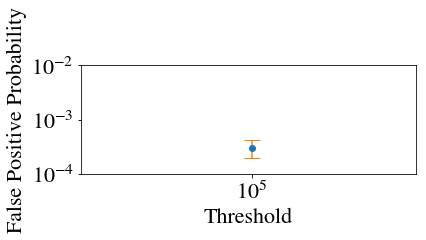

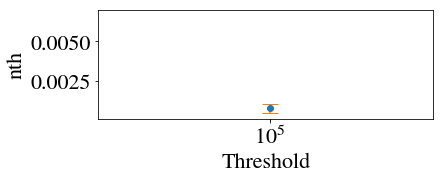

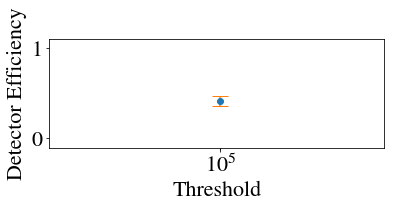

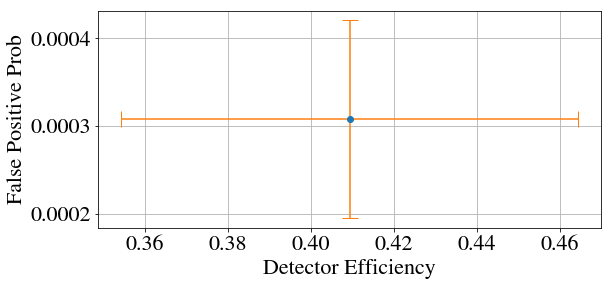

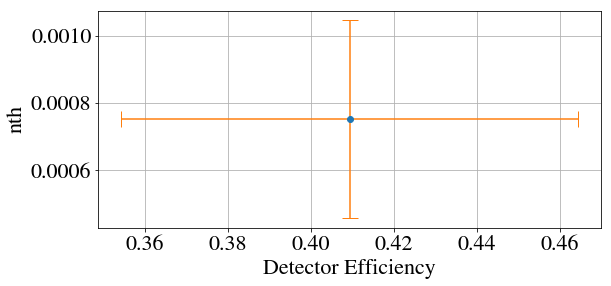

In [ ]:
n_back = asarray(err_list)/asarray(eff_list)
n_back_err = sqrt( (1/asarray(eff_list))**2 * (asarray(err_sigma_list))**2 + (asarray(err_list)/(asarray(eff_list))**2)**2 * (asarray(eff_err_list))**2)


# threshold_list = threshold_list_temp

figure(figsize = (6,2))

plot(threshold_list, err_list, 'o')
errorbar(threshold_list, err_list, yerr = err_sigma_list, fmt=None, capsize = 8)
xscale('symlog', linthreshx = 10**(-4.0))
yscale('symlog', linthreshy=10**(-4.0))
xlabel("Threshold")
ylabel("False Positive Probability")
# title("False Positive Probablity")
ylim(1e-4,1e-2)
# grid()
if save_figs:
    savefig('../figures/falseprob_threshold_25meas.pdf', format='pdf', dpi=1200)
    
figure(figsize = (6,2))
plot(threshold_list, n_back, 'o')
errorbar(threshold_list, n_back, yerr = n_back_err, fmt=None, capsize = 8)
xscale('symlog', linthreshx = 10**(-4.0))
# yscale('symlog', linthreshy=10**(-4.0))
ylim(1e-4,7e-3)
# grid()
xlabel("Threshold")
ylabel("nth")
# title("False Positive Probablity")
# grid()
if save_figs:
    savefig('../figures/nth_threshold_25meas.pdf', format='pdf', dpi=1200)
    

    
figure(figsize = (6,2))
plot(threshold_list, eff_list, 'o')
errorbar(threshold_list, eff_list, yerr = eff_sigma_list, fmt=None, capsize = 8)
xscale('symlog', linthreshx = 10**(-4.0))
# yscale('symlog', linthreshy=10**(-4.0))
xlabel("Threshold")
ylabel("Detector Efficiency")
ylim(-0.1,1.1)
# title("False Positive Probablity")
# grid()
if save_figs:
    savefig('../figures/efficiency_threshold_25meas.pdf', format='pdf', dpi=1200)
    
figure(figsize = (9,4))
# plot(eff_list, nth_list, 'o')
# errorbar(eff_list, nth_list, xerr = eff_err_list, yerr = nth_err_list, fmt=None, capsize = 8)
plot(eff_list, err_list, 'o')
errorbar(eff_list, err_list, xerr = eff_sigma_list, yerr = err_sigma_list, fmt=None, capsize = 8)
# xscale('symlog')
# yscale('symlog', linthreshy=10**(-4.0))
# ylim(0.2,0.8)
ylabel("False Positive Prob")
xlabel("Detector Efficiency")
# title("False Positive Probablity")
grid()
if save_figs:
    savefig('../figures/efficiency_fp_25meas.pdf', format='pdf', dpi=1200)
    
figure(figsize = (9,4))

plot(eff_list, n_back, 'o')
errorbar(eff_list, n_back, xerr = eff_sigma_list, yerr = n_back_err, fmt=None, capsize = 8)
# xscale('symlog')
# yscale('symlog', linthreshy=10**(-4.0))
# ylim(0.2,0.8)
ylabel("nth")
xlabel("Detector Efficiency")
# title("False Positive Probablity")
grid()
if save_figs:
    savefig('../figures/efficiency_fp_25meas.pdf', format='pdf', dpi=1200)

Expected Counts 32.903
n_inj: 0.0822568, N: 400.0
Expected Counts 0.036
n_inj: 0.0000058, N: 6186.0


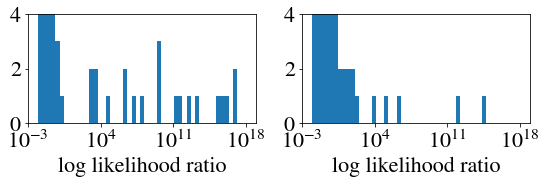

In [ ]:
save_figs = False

thresh = 1e4

L_ratio = {}
for p1 in state_dict:
    state_list = state_dict[p1]
    meas_num_dict[p1] = len(state_list)
    first_detected_state_list = []
    L_ratio_list = []
    for ii in range (len(state_list)):
        meas_seq = state_list[ii][start:stop]
        gamma_matrix = gamma(meas_seq, T, E)

        P0 = gamma_matrix[0,0] + gamma_matrix[0,1]
        P1 = gamma_matrix[0,2] + gamma_matrix[0,3]

        # Compare the probabilities of the two models to obtain a likelihood ratio
        likelihood_ratio_first = P1/P0
#         if likelihood_ratio_first > thresh:
        L_ratio_list.append(likelihood_ratio_first)

    L_ratio[p1] = L_ratio_list

for dic in [L_ratio]:
    del dic[2.7708854882465167e-07]
    del dic[0.01228339687027276]
    
figure(figsize = (9,2))
# for p1 in L_ratio.keys():
for ii,p1 in enumerate([0.082256839612458957,5.8268652271955149e-06], start = 1):
    print("Expected Counts %.3f" %(p1*len(L_ratio[p1])))
    print("n_inj: %.7f, N: %.1f" %(p1, len(L_ratio[p1])))
#     axvline(thresh)
#     title("n_inj: %.7f, N: %.1f" %(p1, len(L_ratio[p1])))
    subplot(1,2,ii)
    hist(L_ratio[p1], bins=logspace(-2,18,50))
    xscale('log')
    ylim(0,4)
    xlabel("log likelihood ratio")
#     ylabel("counts")

if save_figs:
    savefig('../figures/hist_nth.pdf', format='pdf', dpi=1200)